**🔧 Import Required Libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

2025-07-06 15:18:47.632396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751815127.846067      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751815127.907756      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**📁 Load Dataset from Directory**

In [2]:
# Set paths
dataset_path = "/kaggle/input/teeth-dataset-for-classification/Teeth_Dataset"
img_size = (224, 224)
batch_size = 32

# Load datasets
train_ds = image_dataset_from_directory(
    f"{dataset_path}/Training",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = image_dataset_from_directory(
    f"{dataset_path}/Validation",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = image_dataset_from_directory(
    f"{dataset_path}/Testing",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)


Found 3087 files belonging to 7 classes.


I0000 00:00:1751815144.708782      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


**Plot sampile of traning data**

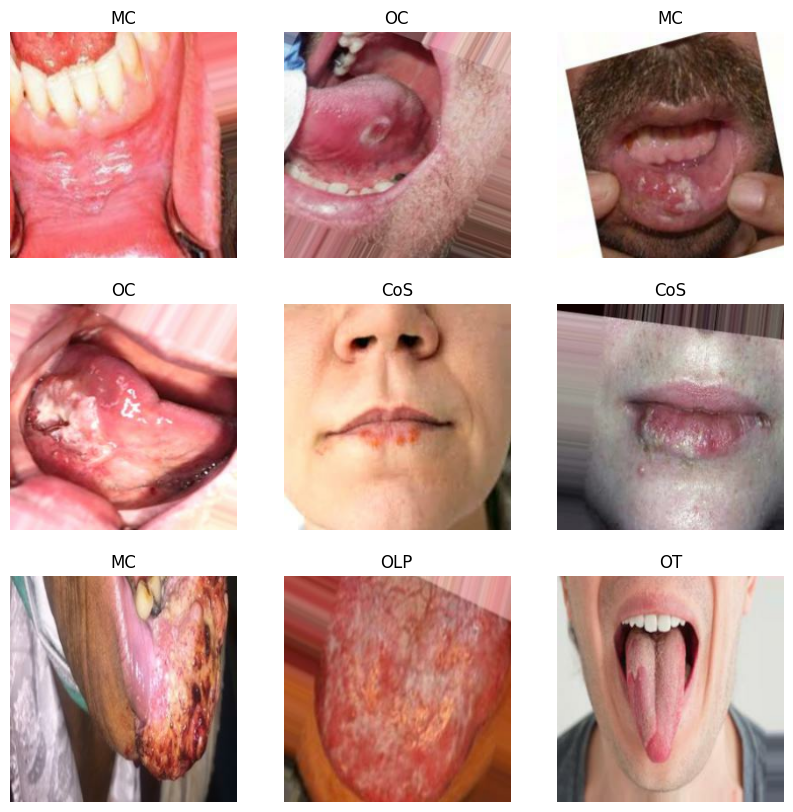

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names
class_names = train_ds.class_names

# Get one batch from train_ds
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i].numpy())
        plt.title(class_names[label_index])
        plt.axis("off")

**Augmentation techniques**

In [4]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

**Plot sample of data after applying augmentation**

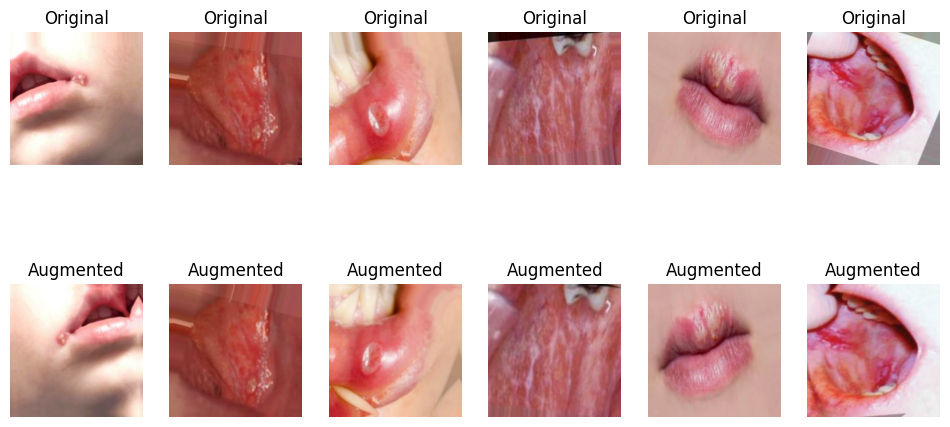

In [5]:
import matplotlib.pyplot as plt

# Take one batch from the training dataset
for images, labels in train_ds.take(1):
    # Apply augmentation
    augmented_images = data_augmentation(images)

    # Show original vs augmented
    plt.figure(figsize=(12, 6))
    for i in range(6):
        # Original
        ax = plt.subplot(2, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")

        # Augmented
        ax = plt.subplot(2, 6, i + 7)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title("Augmented")
        plt.axis("off")
    break

**🧠 Load Pre-trained Model (MobileNetV2)**

In [6]:
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
base_model.trainable = False  # Freeze base

inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(len(train_ds.class_names), activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │           8,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**🏋️‍♂️ Train the Model**

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20


I0000 00:00:1751815161.700913      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.3667 - loss: 1.6769 - val_accuracy: 0.6537 - val_loss: 0.9782
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.6516 - loss: 0.9873 - val_accuracy: 0.7335 - val_loss: 0.7907
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7352 - loss: 0.7715 - val_accuracy: 0.7772 - val_loss: 0.6944
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7608 - loss: 0.6796 - val_accuracy: 0.8035 - val_loss: 0.6219
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.7846 - loss: 0.6163 - val_accuracy: 0.8346 - val_loss: 0.5507
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8338 - loss: 0.5307 - val_accuracy: 0.8298 - val_loss: 0.5344
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8403 - loss: 0.4891 - val_accuracy: 0.8570 - val_loss: 0.4820
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8664 - loss: 0.4530 - val_accuracy: 0.8667 - val_loss: 0

** Evaluate the Model on Test Data**

In [8]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9168 - loss: 0.2821
Test Accuracy: 0.92


**Plot the learning curve**

In [9]:
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plots training and validation accuracy and loss curves.

    Args:
        history: History object returned by model.fit()
    """
    if not hasattr(history, 'history'):
        print("Invalid history object.")
        return

    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    if not acc or not val_acc or not loss or not val_loss:
        print("Missing keys in history.")
        return

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='x')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='x')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

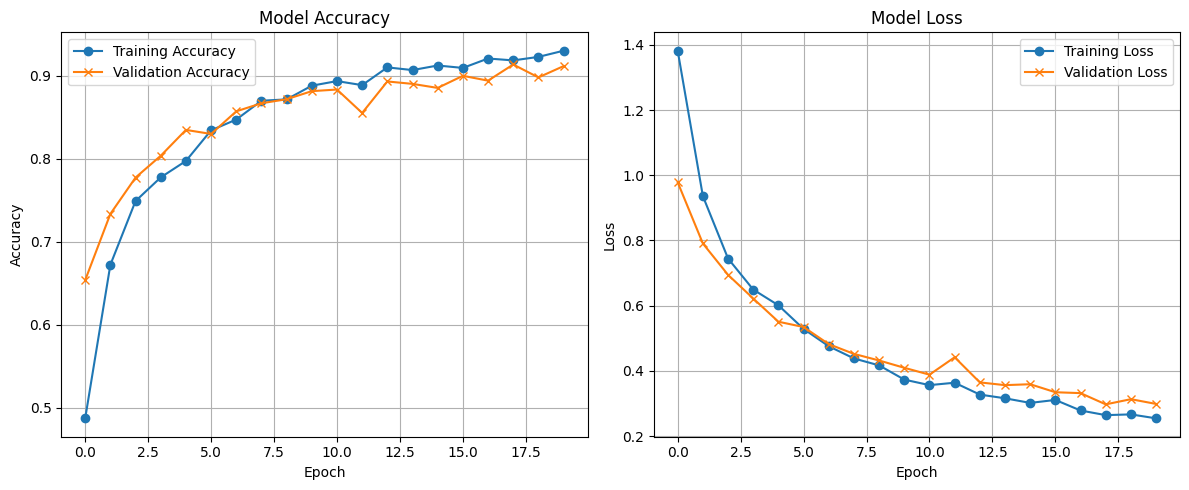

In [10]:
plot_learning_curve(history);

**Save the model**

In [11]:
model.save("teeth_classifier_model.h5")